In [1]:
%matplotlib inline
import os
import cv2
import time
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
from utils.frame_extractor import FrameExtractor

In [3]:
BodyJoint = namedtuple('BodyJoint', ['x','y','z','visibility'])

In [4]:
joints_list = ['NOSE','LEFT_SHOULDER','RIGHT_SHOULDER','LEFT_HIP','RIGHT_HIP','LEFT_ELBOW','RIGHT_ELBOW'
       ,'LEFT_WRIST','RIGHT_WRIST','LEFT_INDEX','RIGHT_INDEX','LEFT_KNEE','RIGHT_KNEE','LEFT_ANKLE'
       ,'RIGHT_ANKLE','LEFT_FOOT_INDEX','RIGHT_FOOT_INDEX']

In [4]:
fex = FrameExtractor()

In [6]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [7]:
def draw_pose(image):
  with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    # Recolor image to RGB
    # image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    # Make detection
    results = pose.process(image)

    # Recolor back to BGR
    image.flags.writeable = True
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # image = frame.copy()

    # Render detections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    # mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
    # mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
  
  return image

In [8]:
ref_vid_path = './resources/videos/jumping_jacks.mp4'
user_vid_path = './resources/videos/squats.mp4'

In [9]:
ref_frames = fex.get_frames(ref_vid_path)

In [10]:
user_frames = fex.get_frames(user_vid_path)

In [13]:
# x1,y1,z1 = 0,-5,0
# x2,y2,z2 = -5,5,0


# np.cross([x1,y1,z1],[x2,y2,z2])

# cosTh = np.dot([x1,y1,z1],[x2,y2,z2])/(np.linalg.norm([x1,y1,z1])*np.linalg.norm([x2,y2,z2]))
# sinTh = np.cross([x1,y1,z1],[x2,y2,z2])/(np.linalg.norm([x1,y1,z1])*np.linalg.norm([x2,y2,z2]))
# print(np.rad2deg(np.arctan2(sinTh,cosTh)))


# dot = x1*x2 + y1*y2 + z1*z2    #between [x1, y1, z1] and [x2, y2, z2]
# lenSq1 = x1*x1 + y1*y1 + z1*z1
# lenSq2 = x2*x2 + y2*y2 + z2*z2
# angle = math.acos(dot/math.sqrt(lenSq1 * lenSq2))

# np.rad2deg(angle)

In [11]:
def get_joints_feats(joint1, joint2, joint3):
  """   returns the weighted average visibility of all the 3 joints and the 
        anti-clockwise angle formed by joint2 with joint1 and joint3
  """
  ab = BodyJoint(joint1.x-joint2.x, joint1.y-joint2.y, joint1.z-joint2.z, 
                   min(joint1.visibility, joint2.visibility))
  bc = BodyJoint(joint3.x-joint2.x, joint3.y-joint2.y, joint3.z-joint2.z,
                   min(joint2.visibility, joint3.visibility))
  dot_prod = (ab.x*bc.x)+(ab.y*bc.y)
  mod_prod = np.sqrt((ab.x**2+ab.y**2)*(bc.x**2+bc.y**2))
  angle = np.rad2deg(np.arccos(dot_prod/mod_prod))   # in degrees
  
  det = ab.x*bc.y - ab.y*bc.x   # determinant for correct quadrant
  angle = 360-angle if det<0 else angle
  visibility = ((1.25*joint1.visibility)+joint2.visibility+(1.25*joint3.visibility))/3.5
  
#   ab = BodyJoint(joint1.x-joint2.x, joint1.y-joint2.y, joint1.z-joint2.z, 
#                    (joint1.visibility+joint2.visibility)/2)
#   bc = BodyJoint(joint3.x-joint2.x, joint3.y-joint2.y, joint3.z-joint2.z,
#                    (joint2.visibility+joint3.visibility)/2)
#   dot_prod = (ab.x*bc.x)+(ab.y*bc.y)+(ab.z*bc.z)
#   mod_prod = np.sqrt((ab.x**2+ab.y**2+ab.z**2)*(bc.x**2+bc.y**2+bc.z**2))
#   angle = np.rad2deg(np.arccos(dot_prod/mod_prod))   # in degrees
  return (visibility, angle)

In [12]:
get_joints_feats(BodyJoint(0,-5,0, 1.0), BodyJoint(0,0,0,1.0), BodyJoint(5,-5,0,1.0))

(1.0, 45.00000000000001)

In [13]:
get_joints_feats(BodyJoint(0,-5,0, 1.0), BodyJoint(0,0,0,1.0), BodyJoint(5,0,0,1.0))

(1.0, 90.0)

In [14]:
get_joints_feats(BodyJoint(0,-5,0, 1.0), BodyJoint(0,0,0,1.0), BodyJoint(0,5,0,1.0))

(1.0, 180.0)

In [15]:
get_joints_feats(BodyJoint(0,-5,0, 1.0), BodyJoint(0,0,0,1.0), BodyJoint(-5,-5,0,1.0))

(1.0, 315.0)

In [16]:
315-45, 360-270

(270, 90)

In [17]:
def get_joints_coordinates(pose_landmarks, frame_shape):
  h, w = frame_shape[:2]
  joints = list()
  for joint_name in joints_list:
    joint = pose_landmarks.landmark[mp_pose.PoseLandmark[joint_name]]
    joint.x, joint.y, joint.z = joint.x*w, joint.y*h, joint.z*w
    joints.append(joint)
  
  return joints

In [18]:
def get_frame_features(frame):
  """   returns the visibility and angle features given a frame   """
  features = list()
  with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    results = pose.process(frame)
    
    if results.pose_landmarks is not None:
      (nose, left_shoulder, right_shoulder, left_hip, right_hip, left_elbow, right_elbow
      , left_wrist, right_wrist, left_index, right_index, left_knee, right_knee, left_ankle
      , right_ankle, left_foot_idx, right_foot_idx) = get_joints_coordinates(results.pose_landmarks, frame.shape)
      
      # Scale Up
#       nose.x, nose.y = nose.x*frame.shape[1], nose.y*frame.shape[0]
#       left_shoulder.x, left_shoulder.y = left_shoulder.x*frame.shape[1], left_shoulder.y*frame.shape[0]
#       right_shoulder.x, right_shoulder.y = right_shoulder.x*frame.shape[1], right_shoulder.y*frame.shape[0]
#       left_hip.x, left_hip.y = left_hip.x*frame.shape[1], left_hip.y*frame.shape[0]
#       right_hip.x, right_hip.y = right_hip.x*frame.shape[1], right_hip.y*frame.shape[0]
#       left_elbow.x, left_elbow.y = left_elbow.x*frame.shape[1], left_elbow.y*frame.shape[0]
#       right_elbow.x, right_elbow.y = right_elbow.x*frame.shape[1], right_elbow.y*frame.shape[0]
#       left_wrist.x, left_wrist.y = left_wrist.x*frame.shape[1], left_wrist.y*frame.shape[0]
#       right_wrist.x, right_wrist.y = right_wrist.x*frame.shape[1], right_wrist.y*frame.shape[0]
#       left_index.x, left_index.y = left_index.x*frame.shape[1], left_index.y*frame.shape[0]
#       right_index.x, right_index.y = right_index.x*frame.shape[1], right_index.y*frame.shape[0]
#       left_knee.x, left_knee.y = left_knee.x*frame.shape[1], left_knee.y*frame.shape[0]
#       right_knee.x, right_knee.y = right_knee.x*frame.shape[1], right_knee.y*frame.shape[0]
#       left_ankle.x, left_ankle.y = left_ankle.x*frame.shape[1], left_ankle.y*frame.shape[0]
#       right_ankle.x, right_ankle.y = right_ankle.x*frame.shape[1], right_ankle.y*frame.shape[0]
#       left_foot_idx.x, left_foot_idx.y = left_foot_idx.x*frame.shape[1], left_foot_idx.y*frame.shape[0]
#       right_foot_idx.x, right_foot_idx.y = right_foot_idx.x*frame.shape[1], right_foot_idx.y*frame.shape[0]

      #for pt in points_list:
      #  visibility_features.append(results.pose_landmarks.landmark[mp_pose.PoseLandmark[pt]].visibility)

      # angle between mid-point of shoulders and nose
      mid_shoulder = BodyJoint((left_shoulder.x+right_shoulder.x)/2,
                               (left_shoulder.y+right_shoulder.y)/2,
                               (left_shoulder.z+right_shoulder.z)/2,
                               (left_shoulder.visibility+right_shoulder.visibility)/2)
      #ang_midshoulders_nose = get_joints_feats(nose, mid_shoulder, left_shoulder)
      features.append(get_joints_feats(nose, mid_shoulder, left_shoulder))

      # angle made by line joining the mid-point of hips and mid-point of shoulders with the ground
      mid_hips = BodyJoint((left_hip.x+right_hip.x)/2, 
                           (left_hip.y+right_hip.y)/2,
                           (left_hip.z+right_hip.z)/2,
                           (left_hip.visibility+right_hip.visibility)/2)
      ground = BodyJoint(mid_hips.x, frame.shape[1], mid_hips.z, 0.9)
      #ang_backbone_ground = angle_between_joints(mid_shoulder, mid_hips, ground)
      features.append(get_joints_feats(mid_shoulder, mid_hips, ground))

      # angle left-hip, left-shoulder, left-elbow
      #ang_lhip_lshoulder_lelbow = angle_between_joints(left_hip, left_shoulder, left_elbow)
      features.append(get_joints_feats(left_hip, left_shoulder, left_elbow))

      # angle right-hip, right-shoulder, right-elbow
      #ang_rhip_rshoulder_relbow = angle_between_joints(right_hip, right_shoulder, right_elbow)
      features.append(get_joints_feats(right_hip, right_shoulder, right_elbow))

      # angle right-shoulder, left-shoulder, left-elbow
      #ang_rshoulder_lshoulder_lelbow = angle_between_joints(right_shoulder, left_shoulder, left_elbow)
      features.append(get_joints_feats(right_shoulder, left_shoulder, left_elbow))

      # angle left-shoulder, right-shoulder, right-elbow
      #ang_lshoulder_rshoulder_relbow = angle_between_joints(left_shoulder, right_shoulder, right_elbow)
      features.append(get_joints_feats(left_shoulder, right_shoulder, right_elbow))

      # angle left-shoulder, left-elbow, left-wrist
      #ang_lshoulder_lelbow_lwrist = angle_between_joints(left_shoulder, left_elbow, left_wrist)
      features.append(get_joints_feats(left_shoulder, left_elbow, left_wrist))

      # angle right-shoulder, right-elbow, right-wrist
      #ang_rshoulder_relbow_rwrist = angle_between_joints(right_shoulder, right_elbow, right_wrist)
      features.append(get_joints_feats(right_shoulder, right_elbow, right_wrist))

      # angle right-elbow, right-wrist, right-index
      #ang_relbow_rwrist_rindex = angle_between_joints(right_elbow, right_wrist, right_index)
      features.append(get_joints_feats(right_elbow, right_wrist, right_index))

      # angle left-elbow, left-wrist, left-index
      # ang_lelbow_lwrist_lindex = angle_between_joints(left_elbow, left_wrist, left_index)
      features.append(get_joints_feats(left_elbow, left_wrist, left_index))

      # angle left-shoulder, left-hip, right-hip
      #ang_lshoulder_lhip_rhip = angle_between_joints(left_shoulder, left_hip, right_hip)
      features.append(get_joints_feats(left_shoulder, left_hip, right_hip))

      # angle right-shoulder, right-hip, left-hip
      # ang_rshoulder_rhip_lhip = angle_between_joints(right_shoulder, right_hip, left_hip)
      features.append(get_joints_feats(right_shoulder, right_hip, left_hip))

      # angle left-hip, right-hip, right-knee
      #ang_lhip_rhip_rknee = angle_between_joints(left_hip, right_hip, right_knee)
      features.append(get_joints_feats(left_hip, right_hip, right_knee))

      # angle right-hip, left-hip, left-knee
      #ang_rhip_lhip_lknee = angle_between_joints(right_hip, left_hip, left_knee)
      features.append(get_joints_feats(right_hip, left_hip, left_knee))

      # angle right-hip, right-knee, right-ankle
      #ang_rhip_rknee_rankle = angle_between_joints(right_hip, right_knee, right_ankle)
      features.append(get_joints_feats(right_hip, right_knee, right_ankle))

      # angle left-hip, left-knee, left-ankle
      #ang_lhip_lknee_lankle = angle_between_joints(left_hip, left_knee, left_ankle)
      features.append(get_joints_feats(left_hip, left_knee, left_ankle))

      # angle right-knee, right-ankle, right-footindex
      #ang_rknee_rankle_rfootIdx = angle_between_joints(right_knee, right_ankle, right_foot_idx)
      features.append(get_joints_feats(right_knee, right_ankle, right_foot_idx))

      # angle left-knee, left-ankle, left-footIndex
      #ang_lknee_lankle_lfootIdx = angle_between_joints(left_knee, left_ankle, left_foot_idx)
      features.append(get_joints_feats(left_knee, left_ankle, left_foot_idx))

      #angle_features = [ang_midshoulders_nose, ang_backbone_ground, ang_lhip_lshoulder_lelbow, 
      #                  ang_rhip_rshoulder_relbow, ang_rshoulder_lshoulder_lelbow, 
      #                 ang_lshoulder_rshoulder_relbow, ang_lshoulder_lelbow_lwrist, 
      #                 ang_rshoulder_relbow_rwrist, ang_relbow_rwrist_rindex, ang_lelbow_lwrist_lindex,
      #                  ang_lshoulder_lhip_rhip, ang_rshoulder_rhip_lhip, ang_lhip_rhip_rknee, 
      #                  ang_rhip_lhip_lknee, ang_rhip_rknee_rankle, ang_lhip_lknee_lankle, 
      #                  ang_rknee_rankle_rfootIdx, ang_lknee_lankle_lfootIdx]
  
  #return visibility_features, angle_features
  return features

In [77]:
# # ref_frames, ref_features = list(), list()
# while vid_reader.isOpened():
#   success, frame = vid_reader.read()
#   if success:
#     frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
#     ref_frames.append(frame)
    
#     with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
#       results = pose.process(frame)
      
#       nose=results.pose_landmarks.landmark[mp_pose.PoseLandmark['NOSE']]
#       left_shoulder=results.pose_landmarks.landmark[mp_pose.PoseLandmark['LEFT_SHOULDER']]
#       right_shoulder=results.pose_landmarks.landmark[mp_pose.PoseLandmark['RIGHT_SHOULDER']]
#       left_hip=results.pose_landmarks.landmark[mp_pose.PoseLandmark['LEFT_HIP']]
#       right_hip=results.pose_landmarks.landmark[mp_pose.PoseLandmark['RIGHT_HIP']]
#       left_elbow=results.pose_landmarks.landmark[mp_pose.PoseLandmark['LEFT_ELBOW']]
#       right_elbow=results.pose_landmarks.landmark[mp_pose.PoseLandmark['RIGHT_ELBOW']]
#       left_wrist=results.pose_landmarks.landmark[mp_pose.PoseLandmark['LEFT_WRIST']]
#       right_wrist=results.pose_landmarks.landmark[mp_pose.PoseLandmark['RIGHT_WRIST']]
#       left_index=results.pose_landmarks.landmark[mp_pose.PoseLandmark['LEFT_INDEX']]
#       right_index=results.pose_landmarks.landmark[mp_pose.PoseLandmark['RIGHT_INDEX']]
#       left_knee=results.pose_landmarks.landmark[mp_pose.PoseLandmark['LEFT_KNEE']]
#       right_knee=results.pose_landmarks.landmark[mp_pose.PoseLandmark['RIGHT_KNEE']]
#       left_ankle=results.pose_landmarks.landmark[mp_pose.PoseLandmark['LEFT_ANKLE']]
#       right_ankle=results.pose_landmarks.landmark[mp_pose.PoseLandmark['RIGHT_ANKLE']]
#       left_foot_idx=results.pose_landmarks.landmark[mp_pose.PoseLandmark['LEFT_FOOT_INDEX']]
#       right_foot_idx=results.pose_landmarks.landmark[mp_pose.PoseLandmark['RIGHT_FOOT_INDEX']]
      
#       not_visible=list()
#       for pt in points_list:
#         if results.pose_landmarks.landmark[mp_pose.PoseLandmark[pt]].visibility <= 0.5:
#           print("%s not visible." %pt)
      
#       # angle between mid-point of shoulders and nose
#       mid_shoulder = BodyJoint((left_shoulder.x+right_shoulder.x)/2, (left_shoulder.y+right_shoulder.y)/2)
#       ang_midshoulders_nose = angle_between_joints(nose, mid_shoulder, left_shoulder)
#       print("%s - %s" %("ang_midshoulders_nose", ang_midshoulders_nose))
      
#       # angle made by line joining the mid-point of hips and mid-point of shoulders with the ground
#       mid_hips = BodyJoint((left_hip.x+right_hip.x)/2, (left_hip.y+right_hip.y)/2)
#       ground = BodyJoint(mid_hips.x, 1.0)
#       ang_backbone_ground = angle_between_joints(mid_shoulder, mid_hips, ground)
#       print("%s - %s" %("ang_backbone_ground", ang_backbone_ground))
      
#       # angle left-hip, left-shoulder, left-elbow
#       ang_lhip_lshoulder_lelbow = angle_between_joints(left_hip, left_shoulder, left_elbow)
#       print("%s - %s" %("ang_lhip_lshoulder_lelbow", ang_lhip_lshoulder_lelbow))
      
#       # angle right-hip, right-shoulder, right-elbow
#       ang_rhip_rshoulder_relbow = angle_between_joints(right_hip, right_shoulder, right_elbow)
#       print("%s - %s" %("ang_rhip_rshoulder_relbow", ang_rhip_rshoulder_relbow))
      
#       # angle right-shoulder, left-shoulder, left-elbow
#       ang_rshoulder_lshoulder_lelbow = angle_between_joints(right_shoulder, left_shoulder, left_elbow)
#       print("%s - %s" %("ang_rshoulder_lshoulder_lelbow", ang_rshoulder_lshoulder_lelbow))
      
#       # angle left-shoulder, right-shoulder, right-elbow
#       ang_lshoulder_rshoulder_relbow = angle_between_joints(left_shoulder, right_shoulder, right_elbow)
#       print("%s - %s" %("ang_lshoulder_rshoulder_relbow", ang_lshoulder_rshoulder_relbow))
      
#       # angle left-shoulder, left-elbow, left-wrist
#       ang_lshoulder_lelbow_lwrist = angle_between_joints(left_shoulder, left_elbow, left_wrist)
#       print("%s - %s" %("ang_lshoulder_lelbow_lwrist", ang_lshoulder_lelbow_lwrist))
      
#       # angle right-shoulder, right-elbow, right-wrist
#       ang_rshoulder_relbow_rwrist = angle_between_joints(right_shoulder, right_elbow, right_wrist)
#       print("%s - %s" %("ang_rshoulder_relbow_rwrist", ang_rshoulder_relbow_rwrist))
      
#       # angle right-elbow, right-wrist, right-index
#       ang_relbow_rwrist_rindex = angle_between_joints(right_elbow, right_wrist, right_index)
#       print("%s - %s" %("ang_relbow_rwrist_rindex", ang_relbow_rwrist_rindex))
      
#       # angle left-elbow, left-wrist, left-index
#       ang_lelbow_lwrist_lindex = angle_between_joints(left_elbow, left_wrist, left_index)
#       print("%s - %s" %("ang_lelbow_lwrist_lindex", ang_lelbow_lwrist_lindex))
      
#       # angle left-shoulder, left-hip, right-hip
#       ang_lshoulder_lhip_rhip = angle_between_joints(left_shoulder, left_hip, right_hip)
#       print("%s - %s" %("ang_lshoulder_lhip_rhip", ang_lshoulder_lhip_rhip))
      
#       # angle right-shoulder, right-hip, left-hip
#       ang_rshoulder_rhip_lhip = angle_between_joints(right_shoulder, right_hip, left_hip)
#       print("%s - %s" %("ang_rshoulder_rhip_lhip", ang_rshoulder_rhip_lhip))
      
#       # angle left-hip, right-hip, right-knee
#       ang_lhip_rhip_rknee = angle_between_joints(left_hip, right_hip, right_knee)
#       print("%s - %s" %("ang_lhip_rhip_rknee", ang_lhip_rhip_rknee))
      
#       # angle right-hip, left-hip, left-knee
#       ang_rhip_lhip_lknee = angle_between_joints(right_hip, left_hip, left_knee)
#       print("%s - %s" %("ang_lhip_rhip_rknee", ang_rhip_lhip_lknee))
      
#       # angle right-hip, right-knee, right-ankle
#       ang_rhip_rknee_rankle = angle_between_joints(right_hip, right_knee, right_ankle)
#       print("%s - %s" %("ang_rhip_rknee_rankle", ang_rhip_rknee_rankle))
      
#       # angle left-hip, left-knee, left-ankle
#       ang_lhip_lknee_lankle = angle_between_joints(left_hip, left_knee, left_ankle)
#       print("%s - %s" %("ang_lhip_lknee_lankle", ang_lhip_lknee_lankle))
      
#       # angle right-knee, right-ankle, right-footindex
#       ang_rknee_rankle_rfootIdx = angle_between_joints(right_knee, right_ankle, right_foot_idx)
#       print("%s - %s" %("ang_rknee_rankle_rfootIdx", ang_rknee_rankle_rfootIdx))
      
#       # angle left-knee, left-ankle, left-footIndex
#       ang_lknee_lankle_lfootIdx = angle_between_joints(left_knee, left_ankle, left_foot_idx)
#       print("%s - %s" %("ang_lknee_lankle_lfootIdx", ang_lknee_lankle_lfootIdx))
      
#     break
#   else:
#     break

In [19]:
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
  frame = cv2.cvtColor(user_frames[16], cv2.COLOR_RGB2BGR)
  results = pose.process(frame)
  print(results)

<class 'mediapipe.python.solution_base.SolutionOutputs'>


In [21]:
left_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark['LEFT_SHOULDER']]
left_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark['LEFT_HIP']]
left_elbow = results.pose_landmarks.landmark[mp_pose.PoseLandmark['LEFT_ELBOW']]

In [22]:
left_shoulder, left_hip, left_elbow

(x: 0.33609825372695923
 y: 0.2650182843208313
 z: 0.3996557891368866
 visibility: 0.9971309304237366,
 x: 0.3131299316883087
 y: 0.5118165612220764
 z: 0.27868741750717163
 visibility: 0.9920163154602051,
 x: 0.49505653977394104
 y: 0.32687753438949585
 z: 0.557437539100647
 visibility: 0.3342360258102417)

In [23]:
h, w = frame.shape[:2]

In [24]:
left_shoulder.x, left_shoulder.y = left_shoulder.x*w, left_shoulder.y*h
left_hip.x, left_hip.y = left_hip.x*w, left_hip.y*h
left_elbow.x, left_elbow.y = left_elbow.x*w, left_elbow.y*h

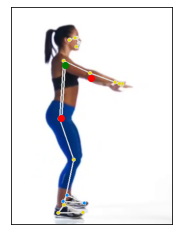

In [23]:
plt.imshow(draw_pose(cv2.cvtColor(user_frames[16], cv2.COLOR_RGB2BGR)))
plt.plot(left_shoulder.x, left_shoulder.y, 'go')
plt.plot(left_hip.x, left_hip.y, 'ro')
plt.plot(left_elbow.x, left_elbow.y, 'ro')
plt.xticks([])
plt.yticks([])
plt.show()

In [44]:
get_joints_feats(left_elbow, left_shoulder, left_hip)

(0.9988426395824977, 40.33419602747899)

In [45]:
get_joints_feats(left_hip, left_shoulder, left_elbow)

(0.9988426395824977, 319.665803972521)

In [81]:
# (960*0.4777287244796753), (540*0.07690232992172241)

In [82]:
# results.pose_landmarks is None

In [83]:
# results.pose_landmarks.landmark[mp_pose.PoseLandmark['LEFT_EYE']]

In [26]:
ref_frames_features = [get_frame_features(frame) for frame in ref_frames]

In [63]:
# def get_similarity(user_angle_feats, ref_angle_feats):
#   diff = 0.0
#   for uangle, rangle in zip(user_angle_feats, ref_angle_feats):
#     diff += min(abs(uangle-rangle), 360-abs(uangle-rangle))/180
#   diff /= len(user_angle_feats)
#   return 1.0-diff

In [60]:
def get_similarity(ref_feats, user_feats):
  ref_feats, user_feats = np.array(ref_feats, dtype=np.float32),np.array(user_feats, dtype=np.float32)
  # absolute difference of visibility and angle features
  diff = np.abs(ref_feats - user_feats)
  # normalise the angle features
  diff[:,1]=np.apply_along_axis(lambda n: min(n[1], 360-n[1])/360.0, axis=1, arr=diff)
  # take average over all rows and then, final weighted average of visibility and angle
  diff = diff.mean(axis=0).flatten()
  #diff = (diff[0]+(1.5*diff[1]))/2.5
  return 1-diff[1]

In [29]:
get_similarity([(1, 10),(0, 10)], [(0, 20), (1, 0)])

0.9444444440305233

In [ ]:
# window = 0
# for uframe in user_frames:
#   plt.imshow(cv2.cvtColor(uframe, cv2.COLOR_RGB2BGR))
#   plt.xticks([])
#   plt.yticks([])
#   plt.show()
  
#   visibility_feats, user_angle_feats = get_frame_features(uframe)
#   if not (len(visibility_feats) > 0 and len(user_angle_feats) > 0):
#     print("Could not extract features")
#     continue
  
#   # check visibility
#   not_visible = list()
#   for i,pt in enumerate(points_list):
#     if ref_frames_features[0][0][i] >= 0.5:
#       if visibility_feats[i]-ref_frames_features[0][0][i] < -0.2:
#         not_visible.append(points_list[i])
  
#   if len(not_visible)>0:
#     print("Parts not visible : %s" %','.join(not_visible))
#     continue
  
#   # check closest frame from the window
#   # for i range(window, window+5):
#   similarity = np.array([get_similarity(user_angle_feats, ref_angle_feats) for _, ref_angle_feats in ref_frames_features])
#   print(similarity.max(), similarity.argmax())
#   print("\n", "-"*100, "\n")

In [24]:
uh,uw,uc = user_frames[0].shape
rh,rw,rc = ref_frames[0].shape

In [25]:
np.pad(ref_frames[0], (((uh-rh)//2,abs(rh-uh)//2),((uw-rw)//2,abs(rw-uw)//2), (0,0)), mode='constant' ).shape

(540, 960, 3)

In [26]:
np.hstack((np.pad(ref_frames[0], (((uh-rh)//2,abs(rh-uh)//2),((uw-rw)//2,abs(rw-uw)//2), (0,0)), mode='constant' ), user_frames[3])).shape

(540, 1920, 3)

In [30]:
window = 0
for ui,uframe in enumerate(user_frames):
  #plt.imshow(cv2.cvtColor(uframe, cv2.COLOR_RGB2BGR))
  #plt.xticks([])
  #plt.yticks([])
  #plt.show()
  
  user_feats = get_frame_features(uframe)
  if len(user_feats)==0:
    print("Could not extract features")
  else:
    # check closest frame from the window
    #for i range(window, window+5):
    #  i = i%len(ref_frames)
    similarity = np.array([get_similarity(ref_feats, user_feats) for ref_feats in ref_frames_features])
    print("Ui: %d   Window: %d" %(ui, window))
    print("Global: ", similarity.max(), similarity.argmax())
    sieve = np.array([similarity[i%len(ref_frames)] for i in range(window,window+5)])
    print("Local: ", sieve.max(), (window+sieve.argmax())%len(ref_frames))
    
    #plt.imshow(cv2.cvtColor(ref_frames[similarity.argmax()], cv2.COLOR_RGB2BGR))
    #plt.xticks([])
    #plt.yticks([])
    #plt.show()
  window = (window+1)%len(ref_frames)
  print("\n", "-"*100, "\n")

Ui: 0   Window: 0
Global:  0.8646797090768814 12
Local:  0.8574407547712326 2

 ---------------------------------------------------------------------------------------------------- 

Ui: 1   Window: 1
Global:  0.8894104585051537 12
Local:  0.8837717771530151 2

 ---------------------------------------------------------------------------------------------------- 

Ui: 2   Window: 2
Global:  0.8877042233943939 12
Local:  0.8844516649842262 2

 ---------------------------------------------------------------------------------------------------- 

Ui: 3   Window: 3
Global:  0.8848637714982033 12
Local:  0.8808059543371201 3

 ---------------------------------------------------------------------------------------------------- 

Ui: 4   Window: 4
Global:  0.7834715396165848 12
Local:  0.7826050221920013 4

 ---------------------------------------------------------------------------------------------------- 

Ui: 5   Window: 5
Global:  0.7518268972635269 4
Local:  0.7431285381317139 5

 ------

In [47]:
# ref_frames_features[7]

In [54]:
# _ref_feats = ref_frames_features[7]
# _user_feats = [(0.9849603772163391, 85.98550399571235), (0.9966110488772393, 355.8803126665982), (0.9879913479089737, 199.31412311143987), (0.9893830269575119, 155.00033181575157), (0.9881830662488937, 93.50544381443436), (0.9882072508335114, 217.81535709475625), (0.9692826867103577, 154.82516055227094), (0.9763399809598923, 201.02244780345788), (0.9778915345668793, 194.11656102270751), (0.9405477046966553, 165.23385234958087), (0.9982949942350388, 276.81742185049285), (0.9996624886989594, 108.19371727448267), (0.9499147236347198, 76.65274734432269), (0.8889579474925995, 253.81682356989637), (0.666413988918066, 181.72954157517125), (0.5364383249543607, 183.50237050009832), (0.24789253994822502, 184.2069556427396), (0.1686700927093625, 192.5339314488513)]

In [55]:
# get_similarity([r[1] for r in _ref_feats], [r[1] for r in _user_feats])

In [56]:
# diff = 0.0
# for uangle, rangle in zip(_user_feats, _ref_feats):
#   vis_diff = abs(uangle[0]-rangle[0])
#   ang_diff = min(abs(uangle[1]-rangle[1]), 360-abs(uangle[1]-rangle[1]))/180
#   print(vis_diff*ang_diff)
#   diff += vis_diff*ang_diff
# diff /= len(_user_feats)


# diff = [0.0, 0.0]
# for uf, rf in zip(_user_feats, _ref_feats):
#   vis_diff = abs(uf[0]-rf[0])
#   ang_diff = min(abs(uf[1]-rf[1]), 360-abs(uf[1]-rf[1]))/180
#   diff[0] += vis_diff
#   diff[1] += ang_diff
#   #diff += vis_diff*ang_diff
#   #print(vis_diff, ang_diff*180)
# diff[0] /= len(_user_feats)
# diff[1] /= len(_user_feats)
# print(1-((diff[0]+diff[1])/2))

In [7]:
# i = 0
# while vid_reader.isOpened():
#   success, frame = vid_reader.read()
#   if success:
#     frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
#     frame = draw_pose(frame)
#     plt.imshow(frame)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title('Frame %d' %(i+1))
#     plt.show()
#     i += 1
#   else:
#     break

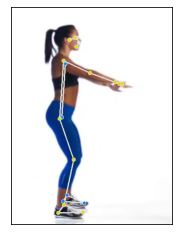

In [46]:
plt.imshow(draw_pose(cv2.cvtColor(user_frames[16], cv2.COLOR_RGB2BGR)))
plt.xticks([])
plt.yticks([])
plt.show()

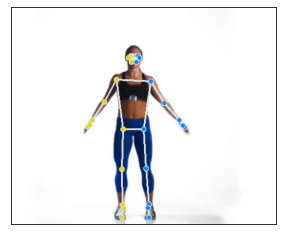

In [23]:
plt.imshow(draw_pose(cv2.cvtColor(ref_frames[4], cv2.COLOR_RGB2BGR)))
plt.xticks([])
plt.yticks([])
plt.show()

In [24]:
get_frame_features(user_frames[16])

[(0.9982067857469831, 113.64790253034813),
 (0.9617259630135128, 175.95975507201678),
 (0.75855610200337, 293.7276367992637),
 (0.9959346694605691, 290.68506515571505),
 (0.7613020241260529, 148.00148514024448),
 (0.997045487165451, 325.13337080807094),
 (0.6265518601451602, 174.00930537713143),
 (0.99159089582307, 175.4099812181356),
 (0.9766971596649715, 169.6575312464405),
 (0.43226756155490875, 154.03730159938095),
 (0.9945587941578456, 242.25232759035458),
 (0.9953349019799914, 62.077870278979525),
 (0.9915294221469334, 94.5840957231051),
 (0.8039764229740415, 275.0314051062035),
 (0.9914868303707668, 211.62081875169312),
 (0.726456058876855, 209.92397217636164),
 (0.9875223636627197, 99.49668378422973),
 (0.652478215949876, 103.78780798326531)]

In [25]:
get_frame_features(ref_frames[4])

[(0.9999760985374451, 92.40757080711514),
 (0.9640647087778363, 179.59461412795224),
 (0.9988426395824977, 319.665803972521),
 (0.9961172427449908, 35.79418061055891),
 (0.9990538103239877, 235.9096567146636),
 (0.9963765868118831, 114.75296301522378),
 (0.9974700510501862, 170.35240453640853),
 (0.9901294835976192, 186.11115358776541),
 (0.9766923359462193, 178.26224545275863),
 (0.9927106201648712, 180.35383444827386),
 (0.9995334190981728, 261.2959241245534),
 (0.9995176110948835, 98.58099446203113),
 (0.9982234878199441, 91.70177705248778),
 (0.9981690900666373, 265.52637654729074),
 (0.9965208215372903, 177.04062660952982),
 (0.9971690305641719, 179.403357871181),
 (0.993307249886649, 180.9180255316041),
 (0.994940630027226, 185.05714132973765)]

In [47]:
_f1 = np.array([f[1] for f in get_frame_features(user_frames[16])])
_f2 = np.array([f[1] for f in get_frame_features(user_frames[12])])

In [31]:
_f1.shape

(18,)

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

In [48]:
cosine_similarity(_f1.reshape(1,-1)/360, _f2.reshape(1,-1)/360)

array([[0.90196089]])

In [49]:
_f1

array([113.64790253, 175.95975507, 293.7276368 , 290.68506516,
       148.00148514, 325.13337081, 174.00930538, 175.40998122,
       169.65753125, 154.0373016 , 242.25232759,  62.07787028,
        94.58409572, 275.03140511, 211.62081875, 209.92397218,
        99.49668378, 103.78780798])

In [50]:
_f2

array([  5.71145267, 152.34784003, 232.25852085, 233.64595488,
       217.53649221,  39.59405134, 174.746562  , 173.42181791,
       164.70552775, 177.5332893 , 193.66158108,  12.99145598,
        46.70650318, 226.80820669, 301.55991095, 301.97534723,
        78.67172372,  86.3658577 ])

In [51]:
np.abs(_f1-_f2)

array([107.93644986,  23.61191505,  61.46911595,  57.03911027,
        69.53500707, 285.53931946,   0.73725663,   1.98816331,
         4.9520035 ,  23.4959877 ,  48.59074651,  49.0864143 ,
        47.87759254,  48.22319842,  89.9390922 ,  92.05137505,
        20.82496006,  17.42195028])

In [54]:
np.mean(np.abs(_f1-_f2)/180)

0.32417273400652324